In [ ]:
!pip install livelossplot
!pip install tensorflow==2.1

In [1]:
from google.colab import files
from urllib.request import urlretrieve
import re
import pandas as pd 
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [3]:
urlretrieve('https://storage.googleapis.com/kaggle-data-sets/609365%2F1120054%2Fcompressed%2F2020-04-01%20Coronavirus%20Tweets.CSV.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1596626176&Signature=Cha6PxWhVwSaba0S80lSu9plWUHxEZHKboThhspKocQAfROvGQI%2F%2F5sbiRitXbhJ%2B20k4YCAxZS9AVmmGGrPsgLVG8%2FBnwOIxh7%2BfSlFBfd9HcK2bPPOaL7PSF6R5OVblP4czs09Ta4BuTi76Zp8SxFTt8e4yEc93%2FzdxmBPYw3FSzj2ZWZWBQ1%2BId56UY60Zm5xosPxHJjaYtnTfWG%2F1KYqiiQYFYn9w1%2Fbd5eGnjTccCXMqIR37HUfgC3Id1InKqXsKMJyNaYaV0hGRVqcVOibfSncpqWAOzPKJVqImySE8IhjxSumnccvHu1QFPXjiJTYZ7OHWdiXVC2OMrKjhw%3D%3D','Dataset.zip')

('Dataset.zip', <http.client.HTTPMessage at 0x7f1cfa9da668>)

In [2]:
!unzip Dataset.zip

Archive:  Dataset.zip
replace 2020-04-01 Coronavirus Tweets.CSV? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
files.upload()

Saving negative_words.txt to negative_words (1).txt
Saving positive_words.txt to positive_words (1).txt


{'negative_words.txt': b'2-faced\r\n2-faces\r\nabnormal\r\nabolish\r\nabominable\r\nabominably\r\nabominate\r\nabomination\r\nabort\r\naborted\r\naborts\r\nabrade\r\nabrasive\r\nabrupt\r\nabruptly\r\nabscond\r\nabsence\r\nabsent-minded\r\nabsentee\r\nabsurd\r\nabsurdity\r\nabsurdly\r\nabsurdness\r\nabuse\r\nabused\r\nabuses\r\nabusive\r\nabysmal\r\nabysmally\r\nabyss\r\naccidental\r\naccost\r\naccursed\r\naccusation\r\naccusations\r\naccuse\r\naccuses\r\naccusing\r\naccusingly\r\nacerbate\r\nacerbic\r\nacerbically\r\nache\r\nached\r\naches\r\nachey\r\naching\r\nacrid\r\nacridly\r\nacridness\r\nacrimonious\r\nacrimoniously\r\nacrimony\r\nadamant\r\nadamantly\r\naddict\r\naddicted\r\naddicting\r\naddicts\r\nadmonish\r\nadmonisher\r\nadmonishingly\r\nadmonishment\r\nadmonition\r\nadulterate\r\nadulterated\r\nadulteration\r\nadulterier\r\nadversarial\r\nadversary\r\nadverse\r\nadversity\r\nafflict\r\naffliction\r\nafflictive\r\naffront\r\nafraid\r\naggravate\r\naggravating\r\naggravation\r

In [4]:
df=pd.read_csv('2020-04-01 Coronavirus Tweets.CSV')
df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1245138808619724800,2722502906,2020-04-01T00:00:00Z,GradaNorteMX,Cuando mejor iban las cosas en el circuito de ...,TweetDeck,NaN,NaN,NaN,False,False,1472,0,NaN,NaN,NaN,1847,252,NaN,2014-08-10T21:20:32Z,False,es
1,1245138810071142405,817072420947247104,2020-04-01T00:00:00Z,Tu_IMSS_Coah,El #Coronavirus se transmite de una persona in...,TweetDeck,NaN,NaN,NaN,False,False,1827,2,NaN,NaN,NaN,1576,169,NaN,2017-01-05T18:17:00Z,False,es
2,1245138809714618368,788863557349670913,2020-04-01T00:00:00Z,Tabasco_IMSS,Una sociedad informada está mejor preparada an...,TweetDeck,NaN,NaN,NaN,False,False,724,1,NaN,NaN,NaN,877,125,NaN,2016-10-19T22:05:03Z,False,es
3,1245138808921874432,131872671,2020-04-01T00:00:00Z,i3health,A records review of patients with #cancer at a...,Buffer,NaN,NaN,NaN,False,False,2576,0,NaN,NaN,NaN,616,4571,NaN,2010-04-11T16:04:57Z,False,en
4,1245138809488056321,35922174,2020-04-01T00:00:00Z,BCGobierno,"Es momento de cuidarnos todos. Por ello, a tra...",TweetDeck,NaN,NaN,NaN,False,False,8516,2,NaN,NaN,NaN,23014,510,NaN,2009-04-28T00:26:21Z,False,es


In [5]:
df=df[df['lang']=='en']

In [6]:
tweetslist=df['text'].values

In [7]:
len(tweetslist)

341697

In [8]:
nltk.download('stopwords')

tweets = [] 
tweets_wrdlist = []

prtstm = PorterStemmer()

for i in tweetslist[200000:300000]:
  tweet = re.sub('[^a-zA-Z]', ' ', i)
  tweet = tweet.lower()
  tweet = tweet.split()
  tweet = [prtstm.stem(word) for word in tweet]
  tweets_wrdlist.append(tweet)
  tweet = ' '.join(tweet)
  tweets.append(tweet)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
fileP=open('positive_words.txt','r')
pos_words=fileP.readlines()
pos_words=set([prtstm.stem(word[0:-1]) for word in pos_words])

In [10]:
fileN=open('negative_words.txt','r')
neg_words=fileN.readlines()
neg_words=set([prtstm.stem(word[0:-1]) for word in neg_words])

In [11]:
labels=[]

for tweet in tweets_wrdlist:
  pos=0
  neg=0
  for word in tweet:
    if word in pos_words:
      pos+=1
    elif word in neg_words:
      neg+=1
  if pos>neg:
    labels.append(1)
  else:
    labels.append(0)

labels=np.array(labels)

In [12]:
countvec = CountVectorizer(max_features = 1000)
features = countvec.fit_transform(tweets).toarray()
features = features.reshape(100000,1000,1)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, MaxPool1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback

model = Sequential()

model.add(Conv1D(input_shape=(1000,1),filters=64,kernel_size=(3),padding="same", activation="relu",))
model.add(Conv1D(filters=64,kernel_size=(3),padding="same", activation="relu"))
model.add(MaxPool1D(pool_size=(2),strides=(2)))

model.add(Conv1D(filters=128, kernel_size=(3), padding="same", activation="relu"))
model.add(Conv1D(filters=128, kernel_size=(3), padding="same", activation="relu"))
model.add(MaxPool1D(pool_size=(2),strides=(2)))

model.add(Conv1D(filters=256, kernel_size=(3), padding="same", activation="relu"))
model.add(Conv1D(filters=256, kernel_size=(3), padding="same", activation="relu"))
model.add(MaxPool1D(pool_size=(2),strides=(2)))

model.add(Flatten())
model.add(Dense(units=512,activation="relu"))
model.add(Dense(units=512,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model.h5', monitor='loss', verbose=0,
    save_best_only=True, mode='auto', save_freq='epoch')

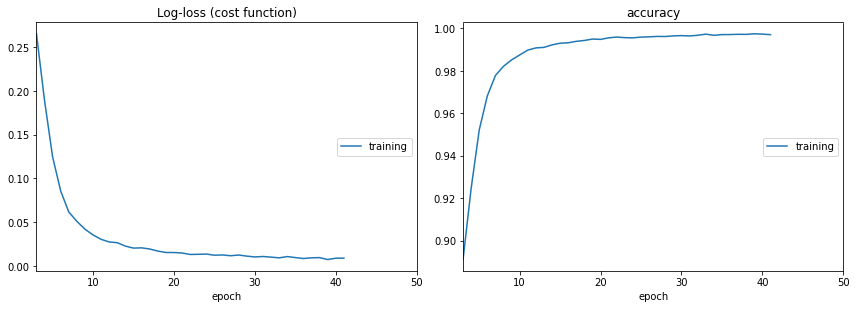

Log-loss (cost function):
training   (min:    0.007, max:    0.412, cur:    0.009)

accuracy:
training   (min:    0.810, max:    0.998, cur:    0.997)
 56960/100000 [================>.............] - ETA: 22s - loss: 0.0088 - accuracy: 0.9971

KeyboardInterrupt: ignored

In [14]:
hist=model.fit(features, labels, epochs=50, batch_size=32, callbacks=[PlotLossesCallback(),checkpoint])

In [ ]:
from tensorflow.keras.models import load_model
model=load_model('model.h5')

In [28]:
twstr='This government sucks, how can they lock millions of people in their homes against their will.'
#twstr='Very poor decision taken by the government. This government in uncapable of running a country'
#twstr='COVID19 lockdown might be bad for humans but for the earth and nature health, it is turning out great'

tweet_str = re.sub('[^a-zA-Z]', ' ', twstr) 
tweet_str = tweet_str.lower() 
tweet_str = tweet_str.split()
prtstm = PorterStemmer() 
tweet_str = [prtstm.stem(word) for word in tweet_str]
tweet_str = ' '.join(tweet_str)
tweet_str=[tweet_str]
feat = countvec.transform(tweet_str).toarray()
feat=feat.reshape(1,1000,1)

ans=model.predict(feat)

print('Negative Probability : {:.2f}'.format(ans[0][0]*100))
print('Positive Probability : {:.2f}'.format(ans[0][1]*100))

Negative Probability : 100.00
Positive Probability : 0.00


In [15]:
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
int(ans[0][1])

0